In [2]:
#PTF_v4_1 Train method file by file added
#runs with functions_v_1_3

In [3]:
import tensorflow as tf

/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [4]:
#Select GPU 0 or 1
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Or 2, 3, etc. other than 0

In [5]:
#set parameters
save_folder = "PTF"         #Name of the Folder in which the results schould be safed

train_file_by_file = True               #True if you want to import the trainingsdata file by file
train_on_folder = False                 #True if you want to train on all data files within this folder, False if you want to train just with one file
train_data_path = "/eos/home-f/frehm/TF2/Data/EleEscan_1_1/EleEscan_1_1.h5" #file
train_folder_path = "/eos/home-f/frehm/TF2/Data//"     #there has to be a folder inside
train_file_by_file_path = "/eos/home-f/frehm/TF2/File_by_file/"         #data on eos
#train_file_by_file_path = "/data/frehm/File_by_file/"                  #data on GPU

learning_rate = 0.001
nb_epochs = 100
percent = 100                       #take just 10 percent of all data for training and testing
latent_size = 200
batch_size =  128                   #128     #batch_size must be less or equal test size, otherwise error
keras_dformat = 'channels_first'    #last for CPU, first for GPU
from PTF_models_v4 import *
from Functions_v1_3 import *

In [6]:
#initialize weights 

#initializer = tf.initializers.glorot_uniform()
initializer = tf.compat.v1.keras.initializers.he_uniform(seed=None)

def get_weight( shape , name ):
    return tf.Variable( initializer( shape ) , name=name , trainable=True , dtype=tf.float32 )

gen_weights = [
    [200, 2401],          #1  dense
    [2401],               #1  bias dense layer
    [5, 5, 5, 7, 64],     #2  conv1  shape=[f1,f2,f3,in_channel, out_channel] 
    [1, 64, 1, 1, 1],     #3  batch offset
    [1, 64, 1, 1, 1],     #4  batch scale
    [6, 6, 6, 16, 64],    #5  conv_transpose1 [f1,f2,f3,out,in]
    [16],                 #6  bias first conv3DTranspose
    [6, 6, 6, 16, 32],    #7  conv2
    [1, 32, 1, 1, 1],     #8  batch offset
    [1, 32, 1, 1, 1],     #9  batch scale
    [4, 4, 4, 32, 16],    #10 conv3
    [1, 16, 1, 1, 1],     #11 batch offset
    [1, 16, 1, 1, 1],     #12 batch scale
    [3, 3, 3, 16, 8],     #13 conv4
    [1, 8, 1, 1, 1],      #14 batch offset
    [1, 8, 1, 1, 1],      #15 batch scale
    [2, 2, 2, 8, 1],      #16 conv_out
]

g_weights = []
for i in range( len( gen_weights ) ):
    if i == len(gen_weights) or i == 0:
        initializer = tf.initializers.glorot_uniform()
        g_weights.append( get_weight( gen_weights[ i ] , 'weight{}'.format( i ) ) )
    else:
        initializer = tf.compat.v1.keras.initializers.he_uniform(seed=None)
        g_weights.append( get_weight( gen_weights[ i ] , 'weight{}'.format( i ) ) )


initializer = tf.compat.v1.keras.initializers.he_uniform(seed=None)
disc_weights = [
    [5, 5, 5, 1, 32],    #0  conv1  shape=[f1,f2,f3,in_channel, out_channel] data_format="NCDHW"
    [32],                #1  bias
    [5, 5, 5, 32, 32],   #2  conv2
    [1, 32, 1, 1, 1],    #3  batch offset
    [1, 32, 1, 1, 1],    #4  batch scale
    [5, 5, 5, 32, 16],   #5  conv3
    [1, 16, 1, 1, 1],    #6  batch offset
    [1, 16, 1, 1, 1],    #7  batch scale
    [5, 5, 5, 16, 16],   #8  conv4
    [1, 16, 1, 1, 1],    #9  batch offset
    [1, 16, 1, 1, 1],    #10 batch scale
    [21296, 1],          #11 dense shape=[in_connections, out_connections]
    [21296, 1],          #12 dense aux
]

d_weights = []
for i in range( len( disc_weights ) ):
    d_weights.append( get_weight( disc_weights[ i ] , 'weight{}'.format( i ) ) )

In [7]:
#reinitialize the batch norm weights: beta to zeros and gammas to ones
g_weights[1] = tf.Variable(tf.zeros_like(g_weights[1]),trainable=True)   #bias
g_weights[3] = tf.Variable(tf.zeros_like(g_weights[3]),trainable=True)
g_weights[4] =  tf.Variable(tf.ones_like(g_weights[4]),trainable=True)
g_weights[6] = tf.Variable(tf.zeros_like(g_weights[6]),trainable=True)   #bias  
g_weights[8] = tf.Variable(tf.zeros_like(g_weights[8]),trainable=True)
g_weights[9] =  tf.Variable(tf.ones_like(g_weights[9]),trainable=True)
g_weights[11] = tf.Variable(tf.zeros_like(g_weights[11]),trainable=True)
g_weights[12] =  tf.Variable(tf.ones_like(g_weights[12]),trainable=True)
g_weights[14] = tf.Variable(tf.zeros_like(g_weights[14]),trainable=True)
g_weights[15] =  tf.Variable(tf.ones_like(g_weights[15]),trainable=True)

d_weights[1] = tf.Variable(tf.zeros_like(d_weights[1]),trainable=True)   #bias
d_weights[3] = tf.Variable(tf.zeros_like(d_weights[3]),trainable=True)
d_weights[4] =  tf.Variable(tf.ones_like(d_weights[4]),trainable=True)
d_weights[6] = tf.Variable(tf.zeros_like(d_weights[6]),trainable=True)
d_weights[7] =  tf.Variable(tf.ones_like(d_weights[7]),trainable=True)
d_weights[9] = tf.Variable(tf.zeros_like(d_weights[9]),trainable=True)
d_weights[10] =  tf.Variable(tf.ones_like(d_weights[10]),trainable=True)

In [8]:
#test networks

inp = tf.Variable(tf.random.normal([2,200]))
#print(inp.numpy())
out = generator(inp, g_weights)
print(out.shape)

inp = tf.Variable(tf.random.normal([2,1,25,25,25]))
#print(inp)
out = (discriminator(inp, d_weights))
#print(out)



(2, 1, 25, 25, 25)


In [9]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

from __future__ import print_function
from collections import defaultdict
try:
    import cPickle as pickle
except ImportError:
    import pickle
import argparse
import os
from six.moves import range
import sys
import h5py 
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import time


In [10]:
#create output folders for saving files and weights
create_folder(save_folder+'/')
create_folder(save_folder+'/Weights/')
create_folder(save_folder+'/Weights/disc')
create_folder(save_folder+'/Weights/gen')
create_folder(save_folder+'/Pickle/')
create_folder(save_folder+'/Save_Images/')
print('*************************************************************************************')

#import trainingsdata
if train_file_by_file == False:
    X,y = import_data(train_on_folder, train_data_path, train_folder_path)
    print('*************************************************************************************') 

    #do data preperation    
    X_train, X_test, y_train, y_test, ecal_train, ecal_test, nb_train, nb_test = data_preperation(X, y, keras_dformat, batch_size, percent)
    y_train = np.expand_dims(y_train, axis=-1)  #macht jeden Eintrag in der Liste zu einer Unterliste [1,2,3]->[[1],[2],[3]]
    y_test  = np.expand_dims(y_test,  axis=-1)
    X_train = tf.constant(X_train)
    X_test  = tf.constant(X_test)
    y_train = np.expand_dims(y_train, axis=-1)  #macht jeden Eintrag in der Liste zu einer Unterliste [1,2,3]->[[1],[2],[3]]
    y_test  = np.expand_dims(y_test,  axis=-1)
    y_train = tf.constant(y_train)
    y_test  = tf.constant(y_test)
    ecal_train = tf.constant(ecal_train)
    ecal_test  = tf.constant(ecal_test)
    print("X_train_shape: ", X_train.shape)
    print("X_test_shape: ", X_test.shape)
    print("ecal_train_shape: ", ecal_train.shape)
    print("ecal_test_shape: ", ecal_test.shape)
    print('*************************************************************************************')
else:
    files = create_files_list(train_file_by_file_path)
    X_test = []
    y_test = []
    ecal_test = []

Directory  PTF_2/  already exists
Directory  PTF_2/Weights/  already exists
Directory  PTF_2/Weights/disc  already exists
Directory  PTF_2/Weights/gen  already exists
Directory  PTF_2/Pickle/  already exists
Directory  PTF_2/Save_Images/  already exists
*************************************************************************************


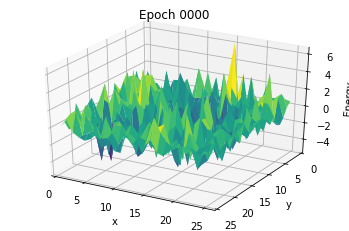

In [11]:
#define plots during training after each epoch

#%matplotlib notebook            #this is for 3D projection
epoch=0

#function for plotting a training images
if train_file_by_file == False:
    plot_images(X, epoch, save_folder, save=False, number=1)

def plot_gen_image_tf(latent_size, g_weights):   #generate a image 
    tf.random.set_seed(1)     
    noise, gen_aux, generator_input, gen_ecal = func_for_gen_tf(1,latent_size=latent_size)
    tf.random.set_seed(None)
    generated_images = generator(generator_input, g_weights)
    generated_images = np.squeeze(generated_images, axis=(1,))
    Xgen = generated_images
    plot_images(Xgen, epoch, save_folder, save=True, number=1)
    return

plot_gen_image_tf(latent_size, g_weights)

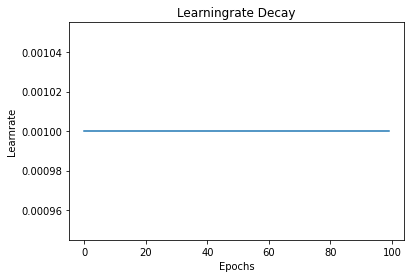

lr last value:  0.001
[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]


In [12]:
#learningrate decay; change parameter k to zero if you don't want to have a decay
from math import *
def l_dec(epoch):
    epoch = epoch - 1 #because training starts at epoch 1
    initial_lrate = learning_rate
    k = 0.0 #0.07
    lrate = initial_lrate * exp(-k*epoch)
    return lrate

ep_list=[]
lr_list=[]
for i in range(0,nb_epochs):
    ep_list.append(i)
    lr_list.append(l_dec(i))

plt.plot(ep_list,lr_list)
plt.title("Learningrate Decay")
plt.xlabel("Epochs")
plt.ylabel("Learnrate")
plt.show()
#print("lr last value: ", round(lr_list[-1],5))
print(lr_list)

Learnrate:  0.001
File:  1 / 20
70/70 [==============================] - 120s 2s/step
File:  2 / 20
70/70 [==============================] - 111s 2s/step
File:  3 / 20
70/70 [==============================] - 111s 2s/step
File:  4 / 20
70/70 [==============================] - 111s 2s/step
File:  5 / 20
70/70 [==============================] - 111s 2s/step
File:  6 / 20
70/70 [==============================] - 112s 2s/step
File:  7 / 20
70/70 [==============================] - 111s 2s/step
File:  8 / 20
70/70 [==============================] - 111s 2s/step
File:  9 / 20
70/70 [==============================] - 111s 2s/step
File:  10 / 20
70/70 [==============================] - 111s 2s/step
File:  11 / 20
70/70 [==============================] - 111s 2s/step
File:  12 / 20
70/70 [==============================] - 111s 2s/step
File:  13 / 20
70/70 [==============================] - 111s 2s/step
File:  14 / 20
70/70 [==============================] - 111s 2s/step
File:  15 / 20
70/70 [===

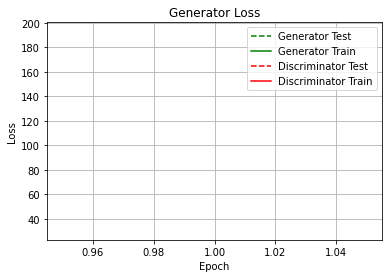

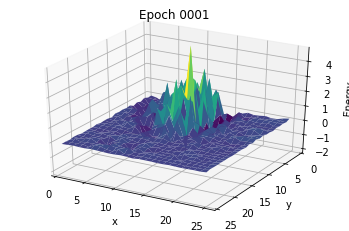

Learnrate:  0.001
File:  1 / 20
70/70 [==============================] - 112s 2s/step
File:  2 / 20
70/70 [==============================] - 112s 2s/step
File:  3 / 20
70/70 [==============================] - 111s 2s/step
File:  4 / 20
70/70 [==============================] - 112s 2s/step
File:  5 / 20
70/70 [==============================] - 112s 2s/step
File:  6 / 20
70/70 [==============================] - 111s 2s/step
File:  7 / 20
70/70 [==============================] - 112s 2s/step
File:  8 / 20
70/70 [==============================] - 111s 2s/step
File:  9 / 20
70/70 [==============================] - 111s 2s/step
File:  10 / 20
70/70 [==============================] - 112s 2s/step
File:  11 / 20
70/70 [==============================] - 112s 2s/step
File:  12 / 20
70/70 [==============================] - 112s 2s/step
File:  13 / 20
70/70 [==============================] - 112s 2s/step
File:  14 / 20
70/70 [==============================] - 112s 2s/step
File:  15 / 20
70/70 [===

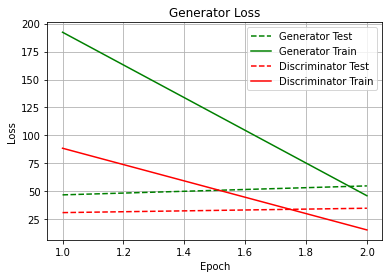

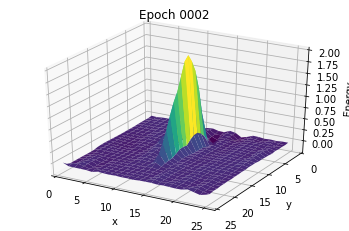

Learnrate:  0.001
File:  1 / 20
70/70 [==============================] - 112s 2s/step
File:  2 / 20
70/70 [==============================] - 112s 2s/step
File:  3 / 20
70/70 [==============================] - 111s 2s/step
File:  4 / 20
70/70 [==============================] - 112s 2s/step
File:  5 / 20
70/70 [==============================] - 111s 2s/step
File:  6 / 20
70/70 [==============================] - 112s 2s/step
File:  7 / 20
70/70 [==============================] - 111s 2s/step
File:  8 / 20
70/70 [==============================] - 111s 2s/step
File:  9 / 20
70/70 [==============================] - 112s 2s/step
File:  10 / 20
70/70 [==============================] - 111s 2s/step
File:  11 / 20
70/70 [==============================] - 112s 2s/step
File:  12 / 20
70/70 [==============================] - 112s 2s/step
File:  13 / 20
70/70 [==============================] - 111s 2s/step
File:  14 / 20
70/70 [==============================] - 112s 2s/step
File:  15 / 20
70/70 [===

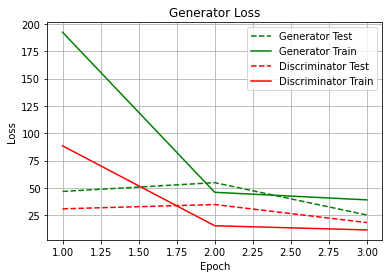

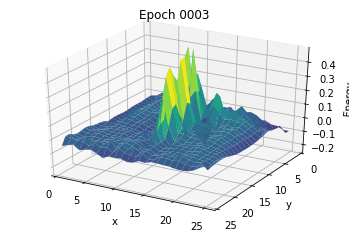

Learnrate:  0.001
File:  1 / 20
70/70 [==============================] - 111s 2s/step
File:  2 / 20
70/70 [==============================] - 111s 2s/step
File:  3 / 20
70/70 [==============================] - 112s 2s/step
File:  4 / 20
70/70 [==============================] - 111s 2s/step
File:  5 / 20
70/70 [==============================] - 111s 2s/step
File:  6 / 20
70/70 [==============================] - 112s 2s/step
File:  7 / 20
70/70 [==============================] - 111s 2s/step
File:  8 / 20
70/70 [==============================] - 111s 2s/step
File:  9 / 20
70/70 [==============================] - 111s 2s/step
File:  10 / 20
70/70 [==============================] - 111s 2s/step
File:  11 / 20
70/70 [==============================] - 112s 2s/step
File:  12 / 20
70/70 [==============================] - 111s 2s/step
File:  13 / 20
70/70 [==============================] - 111s 2s/step
File:  14 / 20
70/70 [==============================] - 112s 2s/step
File:  15 / 20
70/70 [===

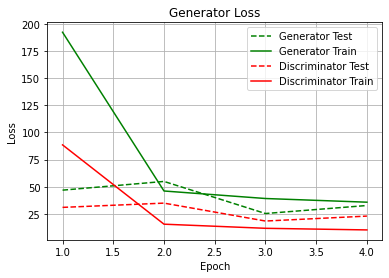

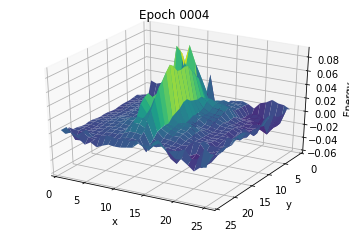

Learnrate:  0.001
File:  1 / 20
70/70 [==============================] - 112s 2s/step
File:  2 / 20
70/70 [==============================] - 112s 2s/step
File:  3 / 20
70/70 [==============================] - 111s 2s/step
File:  4 / 20
70/70 [==============================] - 112s 2s/step
File:  5 / 20
70/70 [==============================] - 112s 2s/step
File:  6 / 20
70/70 [==============================] - 112s 2s/step
File:  7 / 20
70/70 [==============================] - 111s 2s/step
File:  8 / 20
70/70 [==============================] - 111s 2s/step
File:  9 / 20
70/70 [==============================] - 111s 2s/step
File:  10 / 20
70/70 [==============================] - 112s 2s/step
File:  11 / 20
70/70 [==============================] - 111s 2s/step
File:  12 / 20
70/70 [==============================] - 111s 2s/step
File:  13 / 20
70/70 [==============================] - 111s 2s/step
File:  14 / 20
70/70 [==============================] - 111s 2s/step
File:  15 / 20
70/70 [===

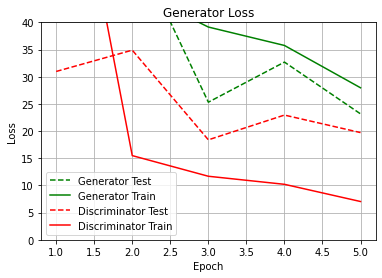

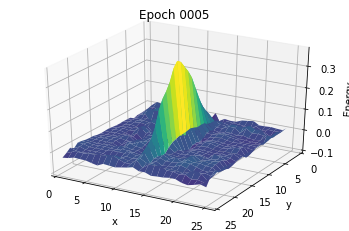

Learnrate:  0.001
File:  1 / 20
70/70 [==============================] - 111s 2s/step
File:  2 / 20
70/70 [==============================] - 111s 2s/step
File:  3 / 20
70/70 [==============================] - 111s 2s/step
File:  4 / 20
70/70 [==============================] - 111s 2s/step
File:  5 / 20
70/70 [==============================] - 111s 2s/step
File:  6 / 20
70/70 [==============================] - 111s 2s/step
File:  7 / 20
70/70 [==============================] - 111s 2s/step
File:  8 / 20
70/70 [==============================] - 111s 2s/step
File:  9 / 20
70/70 [==============================] - 111s 2s/step
File:  10 / 20
70/70 [==============================] - 111s 2s/step
File:  11 / 20
70/70 [==============================] - 111s 2s/step
File:  12 / 20
70/70 [==============================] - 111s 2s/step
File:  13 / 20
70/70 [==============================] - 111s 2s/step
File:  14 / 20
70/70 [==============================] - 111s 2s/step
File:  15 / 20
70/70 [===

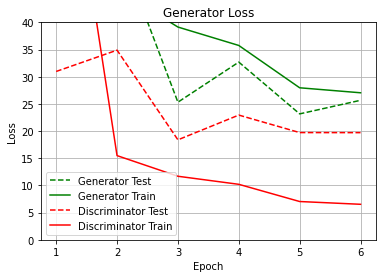

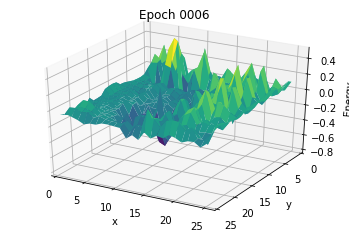

Learnrate:  0.001
File:  1 / 20
70/70 [==============================] - 111s 2s/step
File:  2 / 20
70/70 [==============================] - 111s 2s/step
File:  3 / 20
70/70 [==============================] - 111s 2s/step
File:  4 / 20
70/70 [==============================] - 111s 2s/step
File:  5 / 20
70/70 [==============================] - 113s 2s/step
File:  6 / 20
70/70 [==============================] - 111s 2s/step
File:  7 / 20
70/70 [==============================] - 111s 2s/step
File:  8 / 20
70/70 [==============================] - 111s 2s/step
File:  9 / 20
70/70 [==============================] - 111s 2s/step
File:  10 / 20
70/70 [==============================] - 111s 2s/step
File:  11 / 20
70/70 [==============================] - 111s 2s/step
File:  12 / 20
70/70 [==============================] - 111s 2s/step
File:  13 / 20
70/70 [==============================] - 111s 2s/step
File:  14 / 20
70/70 [==============================] - 111s 2s/step
File:  15 / 20
70/70 [===

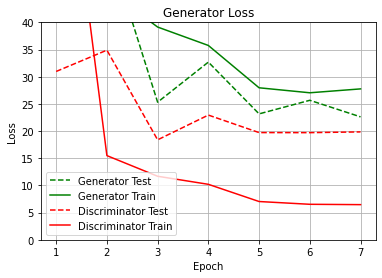

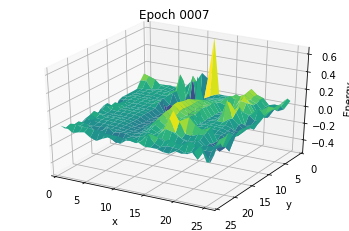

Learnrate:  0.001
File:  1 / 20
70/70 [==============================] - 111s 2s/step
File:  2 / 20
70/70 [==============================] - 111s 2s/step
File:  3 / 20
70/70 [==============================] - 111s 2s/step
File:  4 / 20
70/70 [==============================] - 111s 2s/step
File:  5 / 20
70/70 [==============================] - 111s 2s/step
File:  6 / 20
70/70 [==============================] - 111s 2s/step
File:  7 / 20
70/70 [==============================] - 111s 2s/step
File:  8 / 20
70/70 [==============================] - 111s 2s/step
File:  9 / 20
70/70 [==============================] - 111s 2s/step
File:  10 / 20
70/70 [==============================] - 111s 2s/step
File:  11 / 20
70/70 [==============================] - 111s 2s/step
File:  12 / 20
70/70 [==============================] - 111s 2s/step
File:  13 / 20
70/70 [==============================] - 111s 2s/step
File:  14 / 20
70/70 [==============================] - 111s 2s/step
File:  15 / 20
70/70 [===

In [ ]:
#training
verbose = 'true'

train_history = defaultdict(list)   #create a dict with an empty list 
test_history = defaultdict(list)

start_epoch = 1             #i want to start traing at epoch 1
for epoch in range(start_epoch, nb_epochs + 1):
    print('Epoch {} of {}'.format(epoch, nb_epochs))
    start_epoch = time.time()
    lr = l_dec(epoch)
    print("Learnrate: ", lr)
    optimizer = tf.optimizers.Adam(lr)
    #nb_batches = int(X_train.shape[0] / batch_size)
    epoch_gen_loss = []
    epoch_disc_loss = []
    
    if 'X_test' in locals() and train_file_by_file == True:
        del X_test
        del y_test
        del ecal_test
    if train_file_by_file == False:
        files = [1]
    
    #Iterate over the number of trainingsfiles
    for file_number in range(len(files)):
        #import data file by file
        if train_file_by_file == True:
            print("File: ", file_number+1, "/", len(files))
            X, y = train_file_by_file_import(train_file_by_file_path, files, file_number)
            X_train, X_test_file, y_train, y_test_file, ecal_train, ecal_test_file, nb_train, nb_test = data_preperation(X, y, keras_dformat, batch_size, percent)
            y_train = np.expand_dims(y_train, axis=-1)  #macht jeden Eintrag in der Liste zu einer Unterliste [1,2,3]->[[1],[2],[3]]
            if 'X_test' in locals():
                X_test = np.concatenate((X_test, X_test_file))
                y_test = np.concatenate((y_test, y_test_file))
                ecal_test = np.concatenate((ecal_test, ecal_test_file))
            else: 
                X_test = X_test_file
                y_test = y_test_file
                ecal_test = ecal_test_file
            nb_test=len(y_test)
    
        nb_batches = int(X_train.shape[0] / batch_size)
        if verbose:
            progress_bar = tf.keras.utils.Progbar(target=nb_batches)
        ################################################################################
        
        #loop over epochs
        for batch in range(nb_batches):
            if verbose:
                progress_bar.update(batch+1)
            else:
                if epoch % 100 == 0:
                    print('processed {}/{} batches'.format(batch + 1, nb_batches))

            #create batches
            image_batch  = X_train[(batch*batch_size) : ((batch+1)*batch_size)]
            energy_batch = y_train[(batch*batch_size) : ((batch+1)*batch_size)]
            ecal_batch   = ecal_train[(batch*batch_size) : ((batch+1)*batch_size)]

            #discriminator loss
            with tf.GradientTape(watch_accessed_variables=False) as tape:
                tape.watch(d_weights) 
                discriminator_true = discriminator(image_batch, d_weights)
                d_loss = disc_loss(discriminator_true, energy_batch, ecal_batch, g_weights, d_weights, batch_size)
                d_grads = tape.gradient( d_loss[0] , d_weights )
            optimizer.apply_gradients( zip( d_grads , d_weights) )
            epoch_disc_loss.append([d_loss[0].numpy(), d_loss[1].numpy(), d_loss[2].numpy(), d_loss[3].numpy()])  

            #generator loss
            gen_losses = []
            for i in range(1):
                with tf.GradientTape(watch_accessed_variables=False) as tape:
                    tape.watch(g_weights) 
                    g_loss = gen_loss(g_weights, d_weights, batch_size)
                    g_grads = tape.gradient( g_loss[0] , g_weights )
                optimizer.apply_gradients( zip( g_grads , g_weights ) )
                gen_losses.append([g_loss[0].numpy(), g_loss[1].numpy(), g_loss[2].numpy(), g_loss[3].numpy()])
            epoch_gen_loss.append(np.mean(gen_losses, axis = 0))

    ################################################################################
    #testing
    nb_batches = int(X_test.shape[0] / batch_size)
    if nb_batches == 0:  #I need this or I get an error if I reduce the data with percentage
        nb_batches = 1
    disc_test_loss_list = []
    gen_test_loss_list = []
    for batch in range(nb_batches):
        #create batches
        image_batch  = X_test[(batch*batch_size) : ((batch+1)*batch_size)]
        energy_batch = y_test[(batch*batch_size) : ((batch+1)*batch_size)]
        ecal_batch   = ecal_test[(batch*batch_size) : ((batch+1)*batch_size)]

        discriminator_true = discriminator(image_batch, d_weights)
        disc_test_loss = disc_loss(discriminator_true, energy_batch, ecal_batch, g_weights, d_weights, batch_size)
        disc_test_loss_list.append([disc_test_loss[0].numpy(), disc_test_loss[1].numpy(), disc_test_loss[2].numpy(), disc_test_loss[3].numpy()])

        gen_test_loss = gen_loss(g_weights, d_weights, batch_size)
        gen_test_loss_list.append([gen_test_loss[0].numpy(), gen_test_loss[1].numpy(), gen_test_loss[2].numpy(), gen_test_loss[3].numpy()])

    
    #loss dict
    discriminator_train_loss = np.mean(np.array(epoch_disc_loss), axis=0)   #mean disc loss for all epochs
    generator_train_loss = np.mean(np.array(epoch_gen_loss), axis=0)
    discriminator_test_loss = np.mean(np.array(disc_test_loss_list), axis=0)
    generator_test_loss = np.mean(np.array(gen_test_loss_list), axis=0)
    
    train_history['generator'].append(generator_train_loss)
    train_history['discriminator'].append(discriminator_train_loss)
    test_history['generator'].append(generator_test_loss)
    test_history['discriminator'].append(discriminator_test_loss)
    end_d = time.time()
    
    #calculate time for epoch
    end_batch = time.time()
    e = int(end_batch-start_epoch)
    print('Time for Epoch: {:02d}:{:02d}:{:02d}'.format(e // 3600, (e % 3600 // 60), e % 60))
    
    #print loss table and plot generated image; also save them
    loss_table(train_history, test_history, save_folder, epoch, save=True, timeforepoch = e)
    plot_loss(train_history, test_history, save_folder, save=True)
    
    #dump data
    pickle.dump(d_weights, open(save_folder + "/Weights/disc/disc_weights_"+ str(epoch) + ".p", "wb"))
    pickle.dump(g_weights, open(save_folder + "/Weights/gen/gen_weights_" + str(epoch) + ".p", "wb"))
    pickle.dump([train_history, test_history], open(save_folder+'/Pickle/3dgan-history.pkl', 'wb'))  #my history
    pickle.dump({'train': train_history, 'test': test_history}, open(save_folder+'/Pickle/3dgan-history_dict.pkl', 'wb')) #for validation script

    #plot of generated image
    plot_gen_image_tf(latent_size, g_weights)

In [ ]:
#111s per 10 000 samples
error

## Validation


In [ ]:
#import pickle history
import pickle
pickle_import = pickle.load( open( '/eos/home-f/frehm/TF2/Skripts/F02-03/Runs/run11/run11/Pickle/3dgan-history.pkl', "rb" ) )
#print((pickle_import))
train_history = pickle_import[0]
test_history  = pickle_import[1]

In [ ]:
#load weights
load_epoch = 1
d_weights = pickle.load( open(save_folder + "/Weights/disc/disc_weights_"+ str(load_epoch) + ".p", "rb") )
g_weights = pickle.load( open(save_folder + "/Weights/gen/gen_weights_"+ str(load_epoch) + ".p", "rb") )

In [ ]:
#plot loss graph
plot_loss(train_history, test_history)

In [ ]:
#print table
loss_table(train_history,test_history)

In [ ]:
#plot a trainingsimage

#this is for 3D projection
#%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  #I need this for my plot

#plot some training images
plot_images(X, 0, save_folder, save=False, number=1)

In [ ]:
#plot of generated image
plot_gen_image_tf(latent_size, g_weights)

In [ ]:
error

In [ ]:
#save weights
#pickle.dump( d_weights, open( "d_weights.p", "wb" ) )